# Module 3.2.  Benchmarking the wrangling functions against large datasets
Comparing Python Pandas with PySpark Pandas (Koalas)

### Fabric Prerequistis

You need to have Lakehouse enabled and connected. 

Link to Lakehouse (replace these strings)
- Tables: `abfss://Fabric_2024@onelake.dfs.fabric.microsoft.com/LK_flights.Lakehouse/Tables`
- Files: `abfss://Fabric_2024@onelake.dfs.fabric.microsoft.com/LK_flights.Lakehouse/Files`

You will also need:
- PySpark notebook and connect it to the Fabric standard session

### Columns:

- user_id: Random integer between 1 and 10 million, simulating user IDs.
- transaction_id: Unique transaction ID for each row.
- amount: Random float values between 1 and 1000 (rounded to 2 decimal places), representing transaction amounts.
- category: Randomly chosen from a predefined list of categories (Electronics, Clothing, etc.).
- date: Random dates between January 1, 2020, and January 1, 2023.

### Functions:

- random_date(): Generates random dates within a given range.
- create_large_dataset(): Generates the large dataset using NumPy for random number generation and then stores it in a Pandas DataFrame.

### Saving to CSV:

- The to_csv() function is used to save the DataFrame into a CSV file.

In [14]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

# Parameters
num_rows = 100_000_000  # 100 million rows
categories = ['Electronics', 'Clothing', 'Groceries', 'Health', 'Books']

# Function to generate random dates
def random_date(start, end):
    """Generate a random datetime between `start` and `end`"""
    return start + timedelta(days=random.randint(0, int((end - start).days)))

# Generate the dataset
def create_large_dataset(num_rows):
    # Generate columns
    data = {
        'user_id': np.random.randint(1, 10_000_000, size=num_rows),  # Random user IDs from 1 to 10 million
        'transaction_id': np.arange(1, num_rows + 1),  # Unique transaction IDs
        'amount': np.round(np.random.uniform(1, 1000, size=num_rows), 2),  # Random transaction amounts between 1 and 1000
        'category': np.random.choice(categories, size=num_rows),  # Randomly choose categories
        'date': [random_date(datetime(2020, 1, 1), datetime(2023, 1, 1)) for _ in range(num_rows)]  # Random dates from 2020 to 2023
    }

    # Create DataFrame
    df = pd.DataFrame(data)
    return df

# Create dataset
df = create_large_dataset(num_rows)

# Save to CSV
#csv_file = "large_dataset.csv"
csv_file = "abfss://Fabric_2024@onelake.dfs.fabric.microsoft.com/LK_flights.Lakehouse/Files/large_dataset.csv"
df.to_csv(csv_file, index=False)

print(f"CSV file '{csv_file}' with {num_rows} rows has been created.")


StatementMeta(, 9b3e8d96-aa1c-49a3-8338-8e8415f2088f, 16, Finished, Available, Finished)

CSV file 'abfss://Fabric_2024@onelake.dfs.fabric.microsoft.com/LK_flights.Lakehouse/Files/large_dataset.csv' with 100000000 rows has been created.


Creating 100 million rows may require significant time and memory, so ensure your system has enough resources.

If writing the CSV file takes too long, you can adjust the num_rows parameter to test with a smaller dataset first (e.g., 1_000_000 rows).

## Test

### Python Pandas Code

In [10]:
import pandas as pd

# Load the dataset (assumed to be in CSV or Parquet format)
df = pd.read_csv('abfss://Fabric_2024@onelake.dfs.fabric.microsoft.com/LK_flights.Lakehouse/Files/large_dataset.csv')

# Filtering
filtered_df = df[df['amount'] > 500]

# Grouping and Aggregation
grouped_df = df.groupby('category')['amount'].sum()

# Adding a new column
df['discounted_amount'] = df['amount'] * 0.9

# Handling null values
df.fillna(0, inplace=True)


StatementMeta(, 9b3e8d96-aa1c-49a3-8338-8e8415f2088f, 12, Finished, Available, Finished)

### PySpark Pandas Code

In [ ]:
import pyspark.pandas as ps

# Load the dataset (assumed to be in CSV or Parquet format)
df = ps.read_csv('abfss://Fabric_2024@onelake.dfs.fabric.microsoft.com/LK_flights.Lakehouse/Files/large_dataset.csv')

# Filtering
filtered_df = df[df['amount'] > 500]

# Grouping and Aggregation
grouped_df = df.groupby('category')['amount'].sum()

# Adding a new column
df['discounted_amount'] = df['amount'] * 0.9

# Handling null values
df.fillna(0, inplace=True)


### Combined tests and visualizations

In [30]:
import pandas as pd
import time
import matplotlib.pyplot as plt

# Measure time for each operation
time_results = []

# 1) Reading the file
start_time = time.time()
df = pd.read_csv("/lakehouse/default/Files/large_dataset.csv")
# df = pd.read_csv('abfss://Fabric_2024@onelake.dfs.fabric.microsoft.com/LK_flights.Lakehouse/Files/large_dataset.csv')
read_time = time.time() - start_time
time_results.append({"Library": "Pandas", "Operation": "Read", "Time (s)": read_time})

# 2) Filtering rows where amount > 500
start_time = time.time()
filtered_df = df[df['amount'] > 500]
filter_time = time.time() - start_time
time_results.append({"Library": "Pandas", "Operation": "Filter", "Time (s)": filter_time})

# 3) Grouping and Aggregation (sum of amount grouped by category)
start_time = time.time()
grouped_df = df.groupby('category')['amount'].sum()
group_time = time.time() - start_time
time_results.append({"Library": "Pandas", "Operation": "Group and Aggregate", "Time (s)": group_time})

# 4) Adding new column (discounted_amount = amount * 0.9)
start_time = time.time()
df['discounted_amount'] = df['amount'] * 0.9
add_column_time = time.time() - start_time
time_results.append({"Library": "Pandas", "Operation": "Add Column", "Time (s)": add_column_time})

print("Pandas operations completed")

StatementMeta(, 9b3e8d96-aa1c-49a3-8338-8e8415f2088f, 32, Finished, Available, Finished)

Pandas operations completed


In [23]:
import pyspark.pandas as ps
import time
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.master("local[4]").appName("Benchmark").getOrCreate()

# Measure time for each operation
# We'll append the time for each step to this list
time_results_1 = []

# 1) Reading the file
start_time = time.time()
df = ps.read_csv('abfss://Fabric_2024@onelake.dfs.fabric.microsoft.com/LK_flights.Lakehouse/Files/large_dataset.csv')
read_time = time.time() - start_time
time_results_1.append({"Library": "PySpark Pandas", "Operation": "Read", "Time (s)": read_time})

# 2) Filtering rows where amount > 500
start_time = time.time()
filtered_df = df[df['amount'] > 500]
filter_time = time.time() - start_time
time_results_1.append({"Library": "PySpark Pandas", "Operation": "Filter", "Time (s)": filter_time})

# 3) Grouping and Aggregation (sum of amount grouped by category)
start_time = time.time()
grouped_df = df.groupby('category')['amount'].sum()
group_time = time.time() - start_time
time_results_1.append({"Library": "PySpark Pandas", "Operation": "Group and Aggregate", "Time (s)": group_time})

# 4) Adding new column (discounted_amount = amount * 0.9)
start_time = time.time()
df['discounted_amount'] = df['amount'] * 0.9
add_column_time = time.time() - start_time
time_results_1.append({"Library": "PySpark Pandas", "Operation": "Add Column", "Time (s)": add_column_time})

print("PySpark Pandas operations completed")


StatementMeta(, 9b3e8d96-aa1c-49a3-8338-8e8415f2088f, 25, Finished, Available, Finished)

PySpark Pandas operations completed


/opt/spark/python/lib/pyspark.zip/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.


StatementMeta(, 9b3e8d96-aa1c-49a3-8338-8e8415f2088f, 36, Finished, Available, Finished)

          Library            Operation   Time (s)
0          Pandas                 Read  30.668700
1          Pandas               Filter   1.605232
2          Pandas  Group and Aggregate   4.878992
3          Pandas           Add Column   0.448586
4  PySpark Pandas                 Read  45.813289
5  PySpark Pandas               Filter   0.026252
6  PySpark Pandas  Group and Aggregate   0.035529
7  PySpark Pandas           Add Column   0.008098


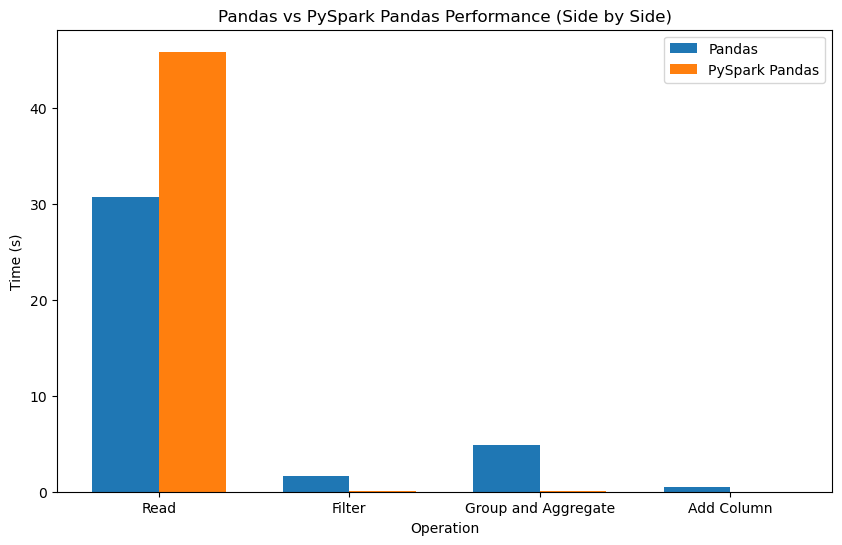

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Example: Assuming time_results_0 and time_results_1 already contain the benchmarking results.

# Combine both lists
combined_results = time_results + time_results_1

# Convert combined results into a Pandas DataFrame
results_df = pd.DataFrame(combined_results)

# Print the combined DataFrame to verify
print(results_df)

# Prepare data for plotting
operations = results_df['Operation'].unique()
libraries = results_df['Library'].unique()

# Initialize a dictionary to store time for each operation, for each library
operation_times = {library: [] for library in libraries}

# Fill in the dictionary with the time values for each library and operation
for operation in operations:
    for library in libraries:
        time = results_df[(results_df['Operation'] == operation) & (results_df['Library'] == library)]['Time (s)'].values
        # Append time to the respective library's list; if no value exists, append 0
        operation_times[library].append(time[0] if len(time) > 0 else 0)

# Set bar width and calculate x positions for each group of bars
bar_width = 0.35
x = np.arange(len(operations))  # the label locations (positions for each operation)

# Plot the bars side by side
plt.figure(figsize=(10, 6))

# Create bars for each library, offset by bar_width
for idx, library in enumerate(libraries):
    plt.bar(x + idx * bar_width, operation_times[library], width=bar_width, label=library)

# Add labels, title, and x-ticks
plt.xlabel("Operation")
plt.ylabel("Time (s)")
plt.title("Pandas vs PySpark Pandas Performance (Side by Side)")
plt.xticks(x + bar_width / 2, operations)  # Align the x-ticks between the groups
plt.legend()

# Display the plot
plt.show()


### Results

1. General Observations

Pandas is preferable for small datasets that fit into memory due to its simpler and more Python API.
PySpark Pandas is ideal for large datasets (in the scale of millions of rows or more), where distributed computing offers significant speed improvements.

2. Conclusion

For small datasets (under a few million rows), Pandas will generally be faster and easier to use.
For big datasets (e.g., tens of millions or more), PySpark Pandas will vastly outperform Pandas due to its ability to distribute operations across multiple nodes.